In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import nibabel as nib
from datetime import datetime
import random
import pdb

import medutils

import torch

#from pytorch3d.transforms import RotateAxisAngle, Rotate, random_rotations

### Load Data and Images

In [6]:
csv_path_raw = '/Users/he/code/vector_neurons_mri/ADNI/other/ADNIMERGE.csv'  # label for each timepoint (CN, AD, Demantia, MCI, LMCI, EMCI)
data_path = '/Users/he/code/vector_neurons_mri/ADNI/other/'
df = pd.read_csv(csv_path_raw, usecols=['PTID', 'DX_bl', 'DX', 'EXAMDATE', 'AGE'])
#df = pd.read_csv(csv_path_raw)

img_paths = glob.glob(data_path + '*.nii.gz')
img_paths = sorted(img_paths)
img_paths

['/Users/he/code/vector_neurons_mri/ADNI/other/002_S_0295-2009-05-22_07_00_57.0.nii.gz']

In [8]:
df.head()

,PTID,EXAMDATE,DX_bl,AGE,DX
0,011_S_0002,2005-09-08,CN,74.3,CN
1,011_S_0003,2005-09-12,AD,81.3,Dementia
2,011_S_0003,2006-03-13,AD,81.3,Dementia
3,011_S_0003,2006-09-12,AD,81.3,Dementia
4,011_S_0003,2007-09-12,AD,81.3,Dementia


In [18]:
df.DX_bl.unique()

array(['CN', 'AD', 'LMCI', 'SMC', 'EMCI', nan], dtype=object)

In [19]:
df.DX.unique()
# CN = Cognitively Normal, AD = Alzheimer's Disease, MCI = Mild Cognitive Impairment

array(['CN', 'Dementia', 'MCI', nan], dtype=object)

In [20]:
print("Loading {} image(s)".format(len(img_paths)))

for img_path in img_paths:
    img_nib = nib.load(os.path.join(img_path))
    img = img_nib.get_fdata()
    #img = (img - np.mean(img)) / np.std(img)
    #subj_img.create_dataset(os.path.basename(img_path), data=img)

Loading 1 image(s)


In [ ]:
# ----- visualize volume -----
medutils.visualization.show(img[5])
#medutils.visualization.show(img)
#plt.show()

### 3D Rotations

In [16]:
img.shape

(64, 64, 64)

In [17]:
img_tensor = torch.from_numpy(img)
img_tensor.shape

torch.Size([64, 64, 64])

In [13]:
x = torch.rand(64, 64, 3)
trot = RotateAxisAngle(angle=90, axis="Z", degrees=True)
x2 = trot.transform_points(x)
#emb2 ,feat = classifier(x2)
#inemb1 = trot.transform_points(emb)
#print (emb2-inemb1)
#print(emb2)

Try using Other possibilites

In [12]:
import numpy as np
from scipy.ndimage import rotate

# Assuming you have a 64x64x64 MRI volume stored in a numpy array called "volume"

# Specify the rotation angle in degrees
rotation_angle = 45

# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)

# Perform the rotation using the rotate function
rotated_volume = rotate(img, rotation_angle, axes=(0, 1), reshape=False)

# Note: The "axes" argument specifies the axes along which the rotation is performed.
# In this example, we are rotating along the first and second axes (axes 0 and 1),
# which correspond to the X and Y dimensions of the volume, respectively.

# The resulting rotated_volume will be a new numpy array with the rotated MRI volume.

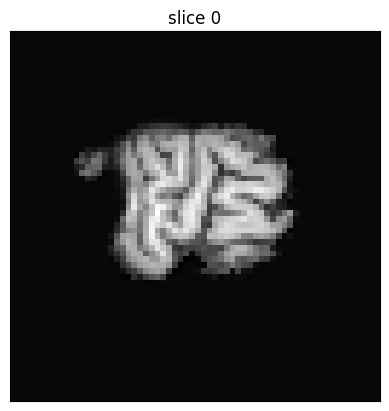

In [14]:
medutils.visualization.show(img[5])

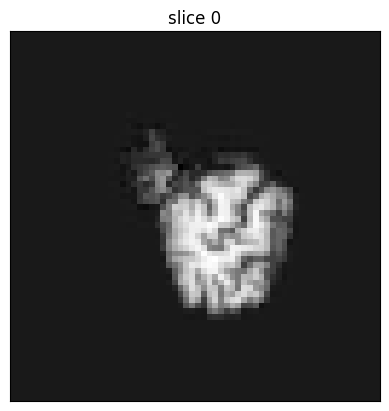

In [13]:
# ----- visualize volume -----
medutils.visualization.show(rotated_volume[5])
#medutils.visualization.show(img)
#plt.show()

### Load 3D volume as point cloud - Custom

In [6]:
# transpose image
img = np.transpose(img, (2, 0, 1))

# ----- normalize image -----
img = medutils.visualization.normalize(img) # to 255 range 
#img = img - np.min(img)


In [10]:
# ----- slice image -----
img = img[0:32, 0:64, 0:64]

In [30]:
# ----- visualize point cloud -----
#x, y, z = np.nonzero(img)
threshold = np.min(img[img > 0]) * 10
print("Threshold: {}".format(threshold))

#x, y, z = np.nonzero(img > 0)
x, y, z = np.nonzero(img > threshold)

Threshold: 43.93803577991966


In [26]:
marker_size = img[x, y, z] / (5 * np.max(img))  # Scale the marker size for visualization

# Convert voxel coordinates to world coordinates
world_coords = np.stack((x, y, z), axis=1)
print(world_coords.shape)

(49860, 3)


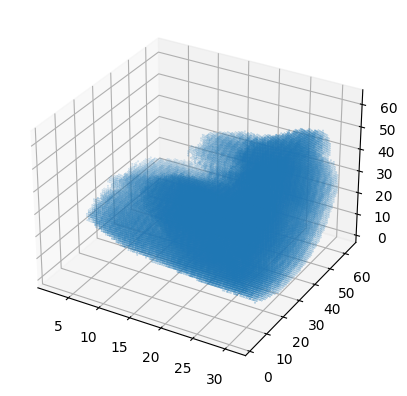

In [27]:
# Visualize point cloud with varying marker size based on intensity
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2], s=marker_size)
plt.show()

Try function by previous researcher

In [12]:
class ImgToPC(object):
    def __call__(self, sample):
        """
        format: for every slice:
        [normalized x, normalized y, intensity]
        
        output shape: [num_slices, sample_width * sample_height, 3]
        """
        ret = torch.tensor([[[i / sample.shape[1], j / sample.shape[2], sample[b][i][j]]for i in range(sample.shape[1]) for j in range(sample.shape[2])] for b in range(sample.shape[0])])
        return ret

In [13]:
points = ImgToPC()(torch.tensor(img))
points.shape

torch.Size([64, 4096, 3])

Try loading into PC and back

In [38]:
import torch
import numpy as np

def PCToImg(point_cloud):
    # return numpy array
    num_slices, num_points, _ = point_cloud.shape
    sample_width = int(np.sqrt(num_points))
    sample_height = int(np.sqrt(num_points))
    volume_shape = (num_slices, sample_width, sample_height)
    #volume_shape = (num_slices, sample_width * 2, sample_height * 2)

    volume = np.zeros(volume_shape)
    for b in range(num_slices):
        for i in range(sample_width):
            for j in range(sample_height):
                x, y, intensity = point_cloud[b, i * sample_height + j]
                volume[b, int(x * sample_width), int(y * sample_height)] = intensity

    return volume


In [39]:
img_restored = PCToImg(points)
assert(img_restored.shape == img.shape)
np.array_equal(img, img_restored)

True

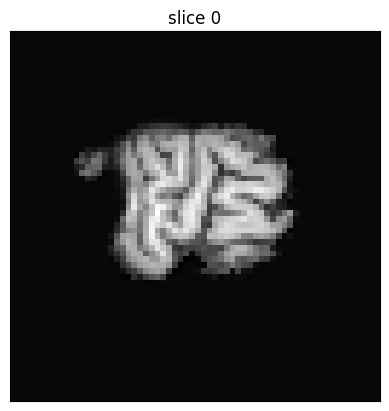

In [40]:
# ----- visualize volume -----
medutils.visualization.show(img_restored[5])

### Combine Tranformation, Convertion to PC and back

In [41]:
points = ImgToPC()(torch.tensor(img))
points.shape

torch.Size([64, 4096, 3])

In [44]:
x = torch.rand(64, 4096, 3)

trot = RotateAxisAngle(angle = 90, axis="Z", degrees=True, dtype=torch.double)

points_rotated = trot.transform_points(points)

img_rotated = PCToImg(points_rotated)
trot.get_matrix()

tensor([[[ 6.1232e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.0000e+00,  6.1232e-17,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       dtype=torch.float64)

issue with non right angle rotations that only work with larger size due to nature of matrix multiplication
-> "crooked" x,y values, pixels are left out

Also, cannot normalize image before rotation, introduced noise


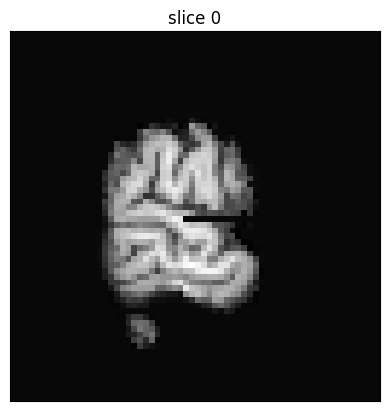

In [45]:
# ----- visualize volume -----
medutils.visualization.show(img_rotated[5])

### Check model dimensions

In [22]:
import os
import glob
import time
import torch
import torch.optim as optim
import numpy as np
import yaml
import pdb
import tqdm
from model import *
from util import *

phase = 'train'

# set seed
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

# model setting
model_name = 'CLS'  
latent_size = 512 #1024
use_feature = ['z', 'delta_z']

# training setting
epochs = 50
batch_size = 64
num_fold = 5
fold = 0
shuffle = True
lr = 0.0001
aug = True

subj_list_postfix = 'C'

# define model
x = torch.rand(batch_size, 64, 64, 64).unsqueeze(1)
print(x.shape)
model = CLS(latent_size, use_feature=use_feature, dropout=True)
pred, z1 = model.forward_single(x)

torch.Size([64, 1, 64, 64, 64])


In [23]:
pred

tensor([[ 4.4664e-01],
        [-1.5727e+00],
        [-5.9104e-01],
        [-5.2605e-01],
        [-3.2310e-01],
        [ 1.3429e+00],
        [-1.9412e-01],
        [-2.5506e+00],
        [-8.4371e-01],
        [-1.0346e+00],
        [-5.0741e-01],
        [-1.1694e+00],
        [-2.0891e+00],
        [ 1.0323e+00],
        [-1.7499e+00],
        [-1.3657e+00],
        [-1.3606e+00],
        [ 9.4948e-01],
        [-1.1843e+00],
        [-7.1843e-01],
        [-8.6362e-01],
        [ 1.2893e+00],
        [-1.4140e+00],
        [ 1.5351e+00],
        [-1.6172e-01],
        [-1.4405e+00],
        [ 9.4400e-02],
        [-4.5394e-01],
        [-5.1222e-01],
        [ 1.1184e+00],
        [-4.9014e-02],
        [-3.0963e-01],
        [ 2.0942e-01],
        [ 1.4039e-02],
        [ 2.9101e-02],
        [-2.4024e-03],
        [-1.8443e+00],
        [-1.3702e+00],
        [-5.1120e-01],
        [ 2.6022e-01],
        [-2.6934e+00],
        [-1.1458e-01],
        [-6.5271e-01],
        [ 3